In [1]:
import re
import pickle
import tarfile
import nltk
import spacy

import pandas as pd

from spacy_lefff import LefffLemmatizer, POSTagger
from spacy.language import Language

import config


# Download the french tokenizer
nltk.download('punkt')

# Need to download the french model first
!python -m spacy download fr_core_news_sm

# Create functions for lemmatisation of French with spaCy
@Language.factory('french_lemmatizer')
def create_french_lemmatizer(nlp, name):
    return LefffLemmatizer(after_melt=True, default=True)
@Language.factory('melt_tagger')  
def create_melt_tagger(nlp, name):
    return POSTagger()

# Print data example with complete content of column 'review'
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 19.6 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


# **Formation NLP**

## Introduction - Analyse de sentiments

Objectif: Déterminer le sentiment d'un texte à l'aide de différentes techniques.

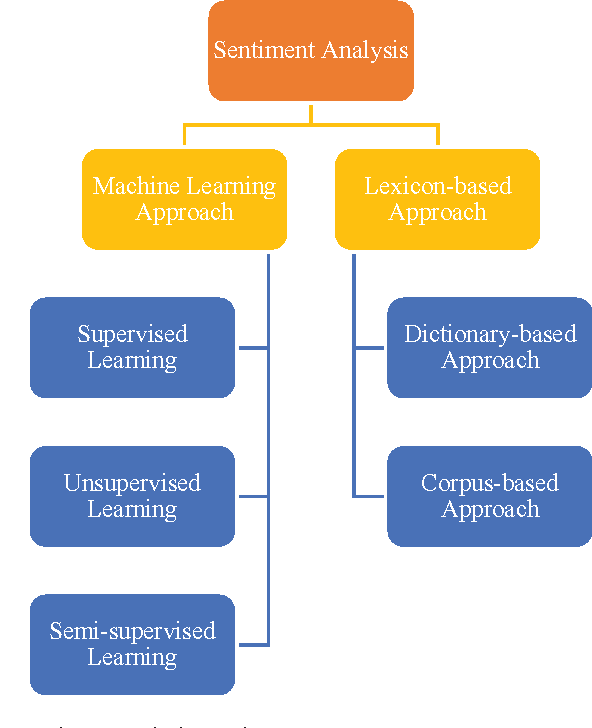






### Approche lexicale 
(*Lexicon or Rule-Based approach*)
  - RegEx
  - NLTK
  - SpaCy

### Machine Learning
  - Modèles à taille fixe
    - Bag of words
  - Modèles réccurents
    - CBOW
  - Modèles transformeurs
    - À affiner (fine-tune)
    - HuggingFace Sentiment Analysis
    - Google's API (sans création de compte)



## Données

Jeu de données pour l'analyse de sentiments: Avis des utilisateurs d'Allociné.fr disponible ici: https://github.com/TheophileBlard/french-sentiment-analysis-with-bert/tree/master/allocine_dataset

Il contient 100 000 avis positifs et 100 000 avis négatifs répartis en 3 répartitions équilibrées : train (160 000 avis), val (20 000) et test (20 000).

**NOTE:** Afin d'optimiser le temps de calcul pour cet exercice, nous allons réduire l'ensemble test 1000. 


**Pré-traitement des données en NLP**

Il existe plusieurs façons de pré-traiter des données textuelles afin d'en faciliter le traitement:
1. Retrait de caractères spéciaux
2. Tokenisation 
3. Radicalisation (stemming et lemmatisation)
Annexe - Mots vides (stop words)
Annexe - POS (étiquetage morpho-syntaxique ou Part-Of-Speech)

In [2]:
# Load data
with tarfile.open(config.base_dir + '/Data/data.tar.bz2', 'r:bz2') as tar:
    datafile = tar.extractfile('data/allocine_dataset.pickle')
    all_data = pickle.load(datafile)

# Display a complete example
all_data["test_set"].head()

,film-url,review,polarity
0,http://www.allocine.fr/film/fichefilm-25385/critiques/spectateurs,"Magnifique épopée, une belle histoire, touchante avec des acteurs qui interprètent très bien leur rôles (Mel Gibson, Heath Ledger, Jason Isaacs...), le genre de film qui se savoure en famille! :)",1
1,http://www.allocine.fr/film/fichefilm-1954/critiques/spectateurs,"Je n'ai pas aimé mais pourtant je lui mets 2 étoiles car l'expérience est louable. Rien de conventionnel ici. Une visite E.T. mais jonchée d'idées /- originales. Le soucis, tout ceci avait-il vraiment sa place dans un film de S.F. tirant sur l'horreur ? Voici un film qui, à l'inverse de tant d'autres qui y ont droit, mériterait peut-être un remake.",0
2,http://www.allocine.fr/film/fichefilm-135523/critiques/spectateurs,Un dessin animé qui brille par sa féerie et ses chansons.,1
3,http://www.allocine.fr/film/fichefilm-61514/critiques/spectateurs,"Si c'est là le renouveau du cinéma français, c'est tout de même foutrement chiant. Si l'objet est très stylisé et la tension palpable, le film paraît plutôt creux.",0
4,http://www.allocine.fr/film/fichefilm-260395/critiques/spectateurs,"Et pourtant on s’en Doutait !Second volet très mauvais, sans fraîcheur et particulièrement lourdingue. Quel dommage.",0


In [3]:
# For test data, we only keep the review and the polarity
test_data = all_data["test_set"].drop(columns=["film-url"])
# Keep only the first 1000 rows for test
test_data = test_data[:1000]

del(all_data)

# Show distribution of polarity (labels)
test_data["polarity"].value_counts()

polarity
0    516
1    484
Name: count, dtype: int64

### Retrait de caractères spéciaux

In [4]:
# Define a function to clean the text
def clean(text):
# Removes all special characters and numericals leaving the alphabets. Return in lower case
    clean_text = re.sub('[^A-Za-zÀ-Ÿ]+', ' ', text)
    return clean_text.lower()

# Cleaning the text in the review column
test_data['clean_review'] = test_data['review'].apply(clean)
test_data.head()



,review,polarity,clean_review
0,"Magnifique épopée, une belle histoire, touchante avec des acteurs qui interprètent très bien leur rôles (Mel Gibson, Heath Ledger, Jason Isaacs...), le genre de film qui se savoure en famille! :)",1,magnifique épopée une belle histoire touchante avec des acteurs qui interprètent très bien leur rôles mel gibson heath ledger jason isaacs le genre de film qui se savoure en famille
1,"Je n'ai pas aimé mais pourtant je lui mets 2 étoiles car l'expérience est louable. Rien de conventionnel ici. Une visite E.T. mais jonchée d'idées /- originales. Le soucis, tout ceci avait-il vraiment sa place dans un film de S.F. tirant sur l'horreur ? Voici un film qui, à l'inverse de tant d'autres qui y ont droit, mériterait peut-être un remake.",0,je n ai pas aimé mais pourtant je lui mets étoiles car l expérience est louable rien de conventionnel ici une visite e t mais jonchée d idées originales le soucis tout ceci avait il vraiment sa place dans un film de s f tirant sur l horreur voici un film qui à l inverse de tant d autres qui y ont droit mériterait peut être un remake
2,Un dessin animé qui brille par sa féerie et ses chansons.,1,un dessin animé qui brille par sa féerie et ses chansons
3,"Si c'est là le renouveau du cinéma français, c'est tout de même foutrement chiant. Si l'objet est très stylisé et la tension palpable, le film paraît plutôt creux.",0,si c est là le renouveau du cinéma français c est tout de même foutrement chiant si l objet est très stylisé et la tension palpable le film paraît plutôt creux
4,"Et pourtant on s’en Doutait !Second volet très mauvais, sans fraîcheur et particulièrement lourdingue. Quel dommage.",0,et pourtant on s en doutait second volet très mauvais sans fraîcheur et particulièrement lourdingue quel dommage


### Tokenisation

Les phrases deviennent des liste de mots

In [5]:
# Without cleaning the reviews, we tokenize
test_data['token_NOT_CLEAN_review'] = test_data['review'].apply(lambda text: nltk.tokenize.word_tokenize(text, language='french'))

In [6]:
# On clean reviews 
test_data['token_review'] = test_data['clean_review'].apply(lambda text: nltk.tokenize.word_tokenize(text, language='french'))
test_data.head()

,review,polarity,clean_review,token_NOT_CLEAN_review,token_review
0,"Magnifique épopée, une belle histoire, touchante avec des acteurs qui interprètent très bien leur rôles (Mel Gibson, Heath Ledger, Jason Isaacs...), le genre de film qui se savoure en famille! :)",1,magnifique épopée une belle histoire touchante avec des acteurs qui interprètent très bien leur rôles mel gibson heath ledger jason isaacs le genre de film qui se savoure en famille,"[Magnifique, épopée, ,, une, belle, histoire, ,, touchante, avec, des, acteurs, qui, interprètent, très, bien, leur, rôles, (, Mel, Gibson, ,, Heath, Ledger, ,, Jason, Isaacs, ..., ), ,, le, genre, de, film, qui, se, savoure, en, famille, !, :, )]","[magnifique, épopée, une, belle, histoire, touchante, avec, des, acteurs, qui, interprètent, très, bien, leur, rôles, mel, gibson, heath, ledger, jason, isaacs, le, genre, de, film, qui, se, savoure, en, famille]"
1,"Je n'ai pas aimé mais pourtant je lui mets 2 étoiles car l'expérience est louable. Rien de conventionnel ici. Une visite E.T. mais jonchée d'idées /- originales. Le soucis, tout ceci avait-il vraiment sa place dans un film de S.F. tirant sur l'horreur ? Voici un film qui, à l'inverse de tant d'autres qui y ont droit, mériterait peut-être un remake.",0,je n ai pas aimé mais pourtant je lui mets étoiles car l expérience est louable rien de conventionnel ici une visite e t mais jonchée d idées originales le soucis tout ceci avait il vraiment sa place dans un film de s f tirant sur l horreur voici un film qui à l inverse de tant d autres qui y ont droit mériterait peut être un remake,"[Je, n'ai, pas, aimé, mais, pourtant, je, lui, mets, 2, étoiles, car, l'expérience, est, louable, ., Rien, de, conventionnel, ici, ., Une, visite, E.T, ., mais, jonchée, d'idées, /-, originales, ., Le, soucis, ,, tout, ceci, avait-il, vraiment, sa, place, dans, un, film, de, S.F, ., tirant, sur, l'horreur, ?, Voici, un, film, qui, ,, à, l'inverse, de, tant, d'autres, qui, y, ont, droit, ,, mériterait, peut-être, un, remake, .]","[je, n, ai, pas, aimé, mais, pourtant, je, lui, mets, étoiles, car, l, expérience, est, louable, rien, de, conventionnel, ici, une, visite, e, t, mais, jonchée, d, idées, originales, le, soucis, tout, ceci, avait, il, vraiment, sa, place, dans, un, film, de, s, f, tirant, sur, l, horreur, voici, un, film, qui, à, l, inverse, de, tant, d, autres, qui, y, ont, droit, mériterait, peut, être, un, remake]"
2,Un dessin animé qui brille par sa féerie et ses chansons.,1,un dessin animé qui brille par sa féerie et ses chansons,"[Un, dessin, animé, qui, brille, par, sa, féerie, et, ses, chansons, .]","[un, dessin, animé, qui, brille, par, sa, féerie, et, ses, chansons]"
3,"Si c'est là le renouveau du cinéma français, c'est tout de même foutrement chiant. Si l'objet est très stylisé et la tension palpable, le film paraît plutôt creux.",0,si c est là le renouveau du cinéma français c est tout de même foutrement chiant si l objet est très stylisé et la tension palpable le film paraît plutôt creux,"[Si, c'est, là, le, renouveau, du, cinéma, français, ,, c'est, tout, de, même, foutrement, chiant, ., Si, l'objet, est, très, stylisé, et, la, tension, palpable, ,, le, film, paraît, plutôt, creux, .]","[si, c, est, là, le, renouveau, du, cinéma, français, c, est, tout, de, même, foutrement, chiant, si, l, objet, est, très, stylisé, et, la, tension, palpable, le, film, paraît, plutôt, creux]"
4,"Et pourtant on s’en Doutait !Second volet très mauvais, sans fraîcheur et particulièrement lourdingue. Quel dommage.",0,et pourtant on s en doutait second volet très mauvais sans fraîcheur et particulièrement lourdingue quel dommage,"[Et, pourtant, on, s, ’, en, Doutait, !, Second, volet, très, mauvais, ,, sans, fraîcheur, et, particulièrement, lourdingue, ., Quel, dommage, .]","[et, pourtant, on, s, en, doutait, second, volet, très, mauvais, sans, fraîcheur, et, particulièrement, lourdingue, quel, dommage]"


In [7]:
# Remove the reviews tokenized from non-cleaned reviews
test_data = test_data.drop(columns=['token_NOT_CLEAN_review'])
test_data.head()

,review,polarity,clean_review,token_review
0,"Magnifique épopée, une belle histoire, touchante avec des acteurs qui interprètent très bien leur rôles (Mel Gibson, Heath Ledger, Jason Isaacs...), le genre de film qui se savoure en famille! :)",1,magnifique épopée une belle histoire touchante avec des acteurs qui interprètent très bien leur rôles mel gibson heath ledger jason isaacs le genre de film qui se savoure en famille,"[magnifique, épopée, une, belle, histoire, touchante, avec, des, acteurs, qui, interprètent, très, bien, leur, rôles, mel, gibson, heath, ledger, jason, isaacs, le, genre, de, film, qui, se, savoure, en, famille]"
1,"Je n'ai pas aimé mais pourtant je lui mets 2 étoiles car l'expérience est louable. Rien de conventionnel ici. Une visite E.T. mais jonchée d'idées /- originales. Le soucis, tout ceci avait-il vraiment sa place dans un film de S.F. tirant sur l'horreur ? Voici un film qui, à l'inverse de tant d'autres qui y ont droit, mériterait peut-être un remake.",0,je n ai pas aimé mais pourtant je lui mets étoiles car l expérience est louable rien de conventionnel ici une visite e t mais jonchée d idées originales le soucis tout ceci avait il vraiment sa place dans un film de s f tirant sur l horreur voici un film qui à l inverse de tant d autres qui y ont droit mériterait peut être un remake,"[je, n, ai, pas, aimé, mais, pourtant, je, lui, mets, étoiles, car, l, expérience, est, louable, rien, de, conventionnel, ici, une, visite, e, t, mais, jonchée, d, idées, originales, le, soucis, tout, ceci, avait, il, vraiment, sa, place, dans, un, film, de, s, f, tirant, sur, l, horreur, voici, un, film, qui, à, l, inverse, de, tant, d, autres, qui, y, ont, droit, mériterait, peut, être, un, remake]"
2,Un dessin animé qui brille par sa féerie et ses chansons.,1,un dessin animé qui brille par sa féerie et ses chansons,"[un, dessin, animé, qui, brille, par, sa, féerie, et, ses, chansons]"
3,"Si c'est là le renouveau du cinéma français, c'est tout de même foutrement chiant. Si l'objet est très stylisé et la tension palpable, le film paraît plutôt creux.",0,si c est là le renouveau du cinéma français c est tout de même foutrement chiant si l objet est très stylisé et la tension palpable le film paraît plutôt creux,"[si, c, est, là, le, renouveau, du, cinéma, français, c, est, tout, de, même, foutrement, chiant, si, l, objet, est, très, stylisé, et, la, tension, palpable, le, film, paraît, plutôt, creux]"
4,"Et pourtant on s’en Doutait !Second volet très mauvais, sans fraîcheur et particulièrement lourdingue. Quel dommage.",0,et pourtant on s en doutait second volet très mauvais sans fraîcheur et particulièrement lourdingue quel dommage,"[et, pourtant, on, s, en, doutait, second, volet, très, mauvais, sans, fraîcheur, et, particulièrement, lourdingue, quel, dommage]"


### Radicalisation 
Un radical est une partie d'un mot responsable de sa signification lexicale. Les deux techniques populaires d'obtention de radicales sont le Stemming et la Lemmatisation.

La principale différence est que Stemming donne souvent des radicales sans signification car il coupe simplement certains caractères à la fin. La lemmatisation donne des radicales significatifs, cependant, elle nécessite des balises POS des mots.

#### Stemming

In [8]:
stemmer = nltk.stem.snowball.FrenchStemmer()

test_data['stem_review'] = test_data['token_review'].apply(lambda l: [stemmer.stem(word) for word in l])
test_data.head()

,review,polarity,clean_review,token_review,stem_review
0,"Magnifique épopée, une belle histoire, touchante avec des acteurs qui interprètent très bien leur rôles (Mel Gibson, Heath Ledger, Jason Isaacs...), le genre de film qui se savoure en famille! :)",1,magnifique épopée une belle histoire touchante avec des acteurs qui interprètent très bien leur rôles mel gibson heath ledger jason isaacs le genre de film qui se savoure en famille,"[magnifique, épopée, une, belle, histoire, touchante, avec, des, acteurs, qui, interprètent, très, bien, leur, rôles, mel, gibson, heath, ledger, jason, isaacs, le, genre, de, film, qui, se, savoure, en, famille]","[magnif, épop, une, bel, histoir, touch, avec, de, acteur, qui, interprètent, tres, bien, leur, rôl, mel, gibson, heath, ledg, jason, isaac, le, genr, de, film, qui, se, savour, en, famill]"
1,"Je n'ai pas aimé mais pourtant je lui mets 2 étoiles car l'expérience est louable. Rien de conventionnel ici. Une visite E.T. mais jonchée d'idées /- originales. Le soucis, tout ceci avait-il vraiment sa place dans un film de S.F. tirant sur l'horreur ? Voici un film qui, à l'inverse de tant d'autres qui y ont droit, mériterait peut-être un remake.",0,je n ai pas aimé mais pourtant je lui mets étoiles car l expérience est louable rien de conventionnel ici une visite e t mais jonchée d idées originales le soucis tout ceci avait il vraiment sa place dans un film de s f tirant sur l horreur voici un film qui à l inverse de tant d autres qui y ont droit mériterait peut être un remake,"[je, n, ai, pas, aimé, mais, pourtant, je, lui, mets, étoiles, car, l, expérience, est, louable, rien, de, conventionnel, ici, une, visite, e, t, mais, jonchée, d, idées, originales, le, soucis, tout, ceci, avait, il, vraiment, sa, place, dans, un, film, de, s, f, tirant, sur, l, horreur, voici, un, film, qui, à, l, inverse, de, tant, d, autres, qui, y, ont, droit, mériterait, peut, être, un, remake]","[je, n, ai, pas, aim, mais, pourt, je, lui, met, étoil, car, l, expérient, est, louabl, rien, de, conventionnel, ici, une, visit, e, t, mais, jonch, d, idé, original, le, souc, tout, cec, avait, il, vrai, sa, plac, dan, un, film, de, s, f, tir, sur, l, horreur, voic, un, film, qui, à, l, invers, de, tant, d, autr, qui, y, ont, droit, mérit, peut, être, un, remak]"
2,Un dessin animé qui brille par sa féerie et ses chansons.,1,un dessin animé qui brille par sa féerie et ses chansons,"[un, dessin, animé, qui, brille, par, sa, féerie, et, ses, chansons]","[un, dessin, anim, qui, brill, par, sa, féer, et, se, chanson]"
3,"Si c'est là le renouveau du cinéma français, c'est tout de même foutrement chiant. Si l'objet est très stylisé et la tension palpable, le film paraît plutôt creux.",0,si c est là le renouveau du cinéma français c est tout de même foutrement chiant si l objet est très stylisé et la tension palpable le film paraît plutôt creux,"[si, c, est, là, le, renouveau, du, cinéma, français, c, est, tout, de, même, foutrement, chiant, si, l, objet, est, très, stylisé, et, la, tension, palpable, le, film, paraît, plutôt, creux]","[si, c, est, là, le, renouveau, du, cinem, franc, c, est, tout, de, mêm, foutr, chi, si, l, objet, est, tres, stylis, et, la, tension, palpabl, le, film, paraît, plutôt, creux]"
4,"Et pourtant on s’en Doutait !Second volet très mauvais, sans fraîcheur et particulièrement lourdingue. Quel dommage.",0,et pourtant on s en doutait second volet très mauvais sans fraîcheur et particulièrement lourdingue quel dommage,"[et, pourtant, on, s, en, doutait, second, volet, très, mauvais, sans, fraîcheur, et, particulièrement, lourdingue, quel, dommage]","[et, pourt, on, s, en, dout, second, volet, tres, mauv, san, fraîcheur, et, particuli, lourdingu, quel, dommag]"


#### Lemmatisation

In [9]:
# Lemmatization for French language with functions created above
nlp = spacy.load('fr_core_news_sm')
nlp.add_pipe('melt_tagger', after='parser')
nlp.add_pipe('french_lemmatizer', after='melt_tagger')

test_data['lem_review'] = test_data['clean_review'].apply(lambda rvw: [d._.lefff_lemma for d in nlp(rvw)])
test_data.head()

,review,polarity,clean_review,token_review,stem_review,lem_review
0,"Magnifique épopée, une belle histoire, touchante avec des acteurs qui interprètent très bien leur rôles (Mel Gibson, Heath Ledger, Jason Isaacs...), le genre de film qui se savoure en famille! :)",1,magnifique épopée une belle histoire touchante avec des acteurs qui interprètent très bien leur rôles mel gibson heath ledger jason isaacs le genre de film qui se savoure en famille,"[magnifique, épopée, une, belle, histoire, touchante, avec, des, acteurs, qui, interprètent, très, bien, leur, rôles, mel, gibson, heath, ledger, jason, isaacs, le, genre, de, film, qui, se, savoure, en, famille]","[magnif, épop, une, bel, histoir, touch, avec, de, acteur, qui, interprètent, tres, bien, leur, rôl, mel, gibson, heath, ledg, jason, isaac, le, genr, de, film, qui, se, savour, en, famill]","[magnifique, épopée, un, beau, histoire, touchant, avec, un, acteur, qui, interpréter, très, bien, son, rôle, mel, gibson, heath, ledger, jason, isaacs, le, genre, de, film, qui, clr, savourer, en, famille]"
1,"Je n'ai pas aimé mais pourtant je lui mets 2 étoiles car l'expérience est louable. Rien de conventionnel ici. Une visite E.T. mais jonchée d'idées /- originales. Le soucis, tout ceci avait-il vraiment sa place dans un film de S.F. tirant sur l'horreur ? Voici un film qui, à l'inverse de tant d'autres qui y ont droit, mériterait peut-être un remake.",0,je n ai pas aimé mais pourtant je lui mets étoiles car l expérience est louable rien de conventionnel ici une visite e t mais jonchée d idées originales le soucis tout ceci avait il vraiment sa place dans un film de s f tirant sur l horreur voici un film qui à l inverse de tant d autres qui y ont droit mériterait peut être un remake,"[je, n, ai, pas, aimé, mais, pourtant, je, lui, mets, étoiles, car, l, expérience, est, louable, rien, de, conventionnel, ici, une, visite, e, t, mais, jonchée, d, idées, originales, le, soucis, tout, ceci, avait, il, vraiment, sa, place, dans, un, film, de, s, f, tirant, sur, l, horreur, voici, un, film, qui, à, l, inverse, de, tant, d, autres, qui, y, ont, droit, mériterait, peut, être, un, remake]","[je, n, ai, pas, aim, mais, pourt, je, lui, met, étoil, car, l, expérient, est, louabl, rien, de, conventionnel, ici, une, visit, e, t, mais, jonch, d, idé, original, le, souc, tout, cec, avait, il, vrai, sa, plac, dan, un, film, de, s, f, tir, sur, l, horreur, voic, un, film, qui, à, l, invers, de, tant, d, autr, qui, y, ont, droit, mérit, peut, être, un, remak]","[je, n, avoir, pas, aimé, mais, pourtant, je, lui, mettre, étoile, car, l, expérience, être, louable, rien, de, conventionnel, ici, un, visite, e, t, mais, jonchée, d, idée, original, le, souci, tout, ceci, avoir, il, vraiment, son, place, dans, un, film, de, s, f, tirant, sur, l, horreur, voici, un, film, qui, à, l, inverse, de, tant, d, autre, qui, y, avoir, droit, mériter, pouvoir, être, un, remake]"
2,Un dessin animé qui brille par sa féerie et ses chansons.,1,un dessin animé qui brille par sa féerie et ses chansons,"[un, dessin, animé, qui, brille, par, sa, féerie, et, ses, chansons]","[un, dessin, anim, qui, brill, par, sa, féer, et, se, chanson]","[un, dessin, animé, qui, briller, par, son, féerie, et, son, chanson]"
3,"Si c'est là le renouveau du cinéma français, c'est tout de même foutrement chiant. Si l'objet est très stylisé et la tension palpable, le film paraît plutôt creux.",0,si c est là le renouveau du cinéma français c est tout de même foutrement chiant si l objet est très stylisé et la tension palpable le film paraît plutôt creux,"[si, c, est, là, le, renouveau, du, cinéma, français, c, est, tout, de, même, foutrement, chiant, si, l, objet, est, très, stylisé, et, la, tension, palpable, le, film, paraît, plutôt, creux]","[si, c, est, là, le, renouveau, du, cinem, franc, c, est, tout, de, mêm, foutr, chi, si, l, objet, est, tres, stylis, et, la, tension, palpabl, le, film, paraît, plutôt, creux]","[si, c, être, là, le, renouve

In [10]:
# Save
test_data.to_csv(config.base_dir + '/Data/prepro_test_data.csv', index=False)

## Annexe

### POS

In [11]:
nlp = spacy.load('fr_core_news_sm')

doc = nlp('Demain, je travaille de très belle maison. Tu es beau')
for token in doc:
    print(token.text, token.pos_, token.lemma_)

Demain ADV demain
, PUNCT ,
je PRON je
travaille VERB travailler
de ADP de
très ADV très
belle ADJ bel
maison NOUN maison
. PUNCT .
Tu ADJ taire
es DET être
beau NOUN beau


In [12]:
# Add Spacy French extension
nlp.add_pipe('melt_tagger', after='parser')
nlp.add_pipe('french_lemmatizer', after='melt_tagger')

doc = nlp("Demain, je travaille de très belle maison et tu es beau")
for d in doc:
    print(d.text, d.pos_, d._.melt_tagger, d._.lefff_lemma, d.tag_, d.lemma_)

Demain ADV ADV demain ADV demain
, PUNCT PONCT , PUNCT ,
je PRON CLS je PRON je
travaille VERB V travailler VERB travailler
de ADP P de ADP de
très ADV ADV très ADV très
belle ADJ ADJ beau ADJ bel
maison NOUN NC maison NOUN maison
et CCONJ CC et CCONJ et
tu VERB CLS tu VERB taire
es DET V être DET être
beau NOUN ADJ beau NOUN beau


### Mots vides (stop words)

In [13]:
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('french')
stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['au',
 'aux',
 'avec',
 'ce',
 'ces',
 'dans',
 'de',
 'des',
 'du',
 'elle',
 'en',
 'et',
 'eux',
 'il',
 'ils',
 'je',
 'la',
 'le',
 'les',
 'leur',
 'lui',
 'ma',
 'mais',
 'me',
 'même',
 'mes',
 'moi',
 'mon',
 'ne',
 'nos',
 'notre',
 'nous',
 'on',
 'ou',
 'par',
 'pas',
 'pour',
 'qu',
 'que',
 'qui',
 'sa',
 'se',
 'ses',
 'son',
 'sur',
 'ta',
 'te',
 'tes',
 'toi',
 'ton',
 'tu',
 'un',
 'une',
 'vos',
 'votre',
 'vous',
 'c',
 'd',
 'j',
 'l',
 'à',
 'm',
 'n',
 's',
 't',
 'y',
 'été',
 'étée',
 'étées',
 'étés',
 'étant',
 'étante',
 'étants',
 'étantes',
 'suis',
 'es',
 'est',
 'sommes',
 'êtes',
 'sont',
 'serai',
 'seras',
 'sera',
 'serons',
 'serez',
 'seront',
 'serais',
 'serait',
 'serions',
 'seriez',
 'seraient',
 'étais',
 'était',
 'étions',
 'étiez',
 'étaient',
 'fus',
 'fut',
 'fûmes',
 'fûtes',
 'furent',
 'sois',
 'soit',
 'soyons',
 'soyez',
 'soient',
 'fusse',
 'fusses',
 'fût',
 'fussions',
 'fussiez',
 'fussent',
 'ayant',
 'ayante',
 'ayantes',
